In [1]:
import numpy as np
import mlgrad.model as model
import mlgrad.loss as loss
import mlgrad.func as func
import mlgrad.avragg as avragg
# import mlgrad.gd as gd
# import mlgrad.regular as regular
import mlgrad.weights as weights
from mlgrad.utils import array_exclude_outliers

import mlgrad.regr as regr

from mlgrad import averager_it, averager_fg, fg, erm_fg, sg, erm_sg, irgd, erm_irgd, erisk, mrisk

#import sklearn.linear_model as sklm

import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['seaborn-notebook', 'seaborn-ticks'])

import sys
print(sys.version)

3.9.2 (default, Feb 28 2021, 17:03:44) 
[GCC 10.2.1 20210110]


In [2]:
df = pd.read_csv("data/starsCYG.csv", sep=',', usecols=["log.Te", "log.light"], )

In [3]:
len(df)

47

In [4]:
Y = df["log.light"].values
X = df["log.Te"].values

X -= np.median(X)
Y -= np.median(Y)

# x_min, x_max = X.min(), X.max()
# X = (X - x_min) / (x_max - x_min)
# y_min, y_max = Y.min(), Y.max()
# Y = (Y - y_min) / (y_max - y_min)

Xs = X.reshape((-1,1))

X0 = np.linspace(X.min(), X.max(), 20)

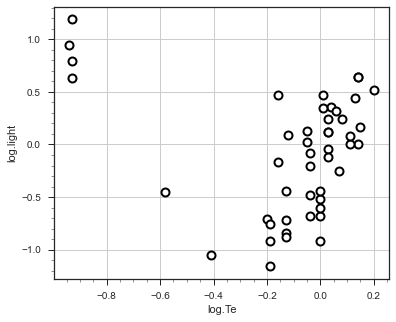

In [5]:
plt.figure(figsize=(6.0, 5.0))
plt.scatter(X, Y, s=64, c='w', edgecolors='k', linewidths=2.)
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
# plt.xlim(-0.9, 0.6)
# plt.ylim(-2.5, 2.0)
plt.show()

In [6]:
loss_func_sq = loss.ErrorLoss(func.Square())
loss_func_rsq = loss.RelativeErrorLoss(func.Square())
loss_func_abs = loss.ErrorLoss(func.Absolute())

In [7]:
mod1 = model.LinearModel(1)
mod1.init()

print(np.array(mod1.param))

[0.40005266 0.78892003]


step: 1
K=1000 param=[-0.0918141  -0.11640928]


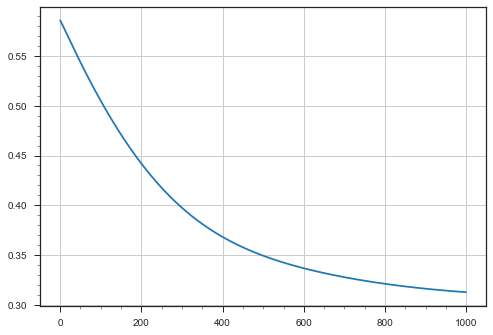

In [8]:
alg_fg1 = regr.regression(Xs, Y, mod1)

plt.plot(alg_fg1.lvals)
plt.minorticks_on()
plt.grid(1)
plt.show()

In [9]:
mod2 = model.LinearModel(1)
mod2.init()

step: 1


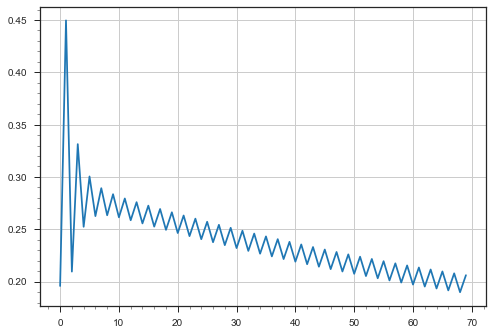

In [10]:
avg2 = regr.averaging_function('WM', rhofunc=func.Quantile_Sqrt(0.84, 0.001))
irgd2 = regr.m_regression_irls(Xs, Y, mod2, avrfunc=avg2, h=0.001, n_iter2=70)

plt.plot(irgd2.lvals)
plt.minorticks_on()
plt.grid(1)
plt.show()

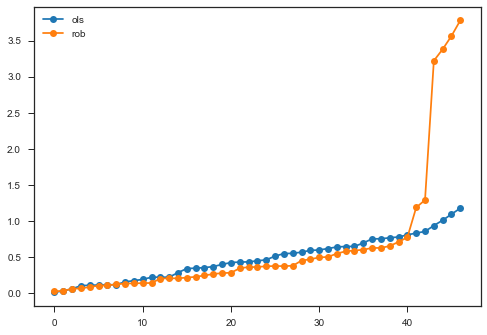

In [11]:
res1 = np.abs(Y - mod1.evaluate_all(Xs))
res1.sort()
res2 = np.abs(Y - mod2.evaluate_all(Xs))
res2.sort()
#ranges = np.arange(len(res1))

plt.plot(res1, marker='o', label='ols')
plt.plot(res2, marker='o', label='rob')
plt.legend()
plt.show()

In [12]:
Err = np.abs(Y - mod2.evaluate_all(Xs))

X1, X1_ = array_exclude_outliers(X, Err, 7) 
Y1, Y1_ = array_exclude_outliers(Y, Err, 7) 
X1s = X1.reshape(-1,1)

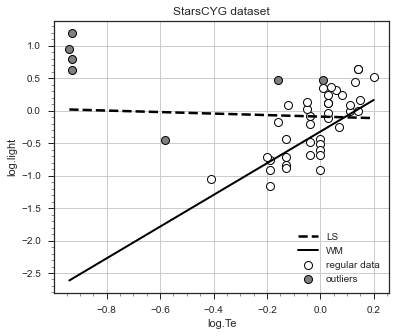

In [13]:
plt.figure(figsize=(6.0, 5.0))
plt.title('StarsCYG dataset')
plt.scatter(X1, Y1, s=64, c='w', edgecolors='k', linewidths=1., label='regular data')
plt.scatter(X1_, Y1_, s=64, c='Grey', edgecolors='k', linewidths=1., label='outliers')
plt.plot(X0, mod1.evaluate_all(X0.reshape(-1,1)), c='k', linestyle='--', linewidth=2.5, label=r'LS')
plt.plot(X0, mod2.evaluate_all(X0.reshape(-1,1)), color='k', linewidth=2., label=r'WM')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
# plt.xlim(-0.9, 0.6)
# plt.ylim(-2.5, 2.0)
plt.legend(loc='best')
plt.show()

In [14]:
mod2s = model.LinearModel(1)
mod2s.init()

step: 1


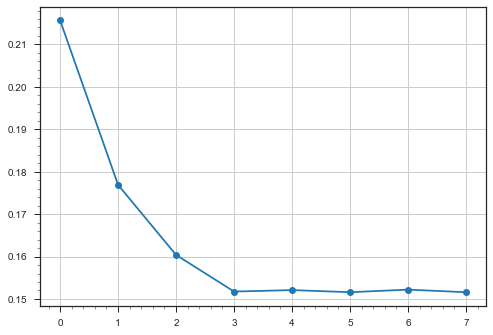

In [15]:
avg2s = regr.averaging_function('SWM', rhofunc=func.QuantileFunc(0.85, func.Sqrt(0.001)))
irgd2s = regr.m_regression_irls(Xs, Y, mod2s, avrfunc=avg2s, h=0.001, tol=1.0e-8)

plt.plot(irgd2s.lvals, marker='o')
plt.minorticks_on()
plt.grid(1)
plt.show()

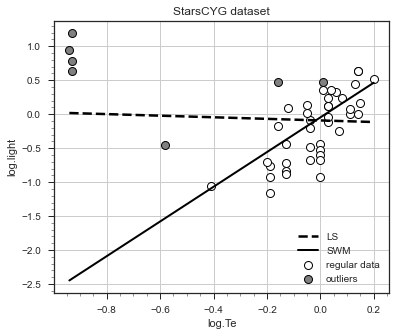

In [16]:
plt.figure(figsize=(6.0, 5.0))
plt.title('StarsCYG dataset')
plt.scatter(X1, Y1, s=64, c='w', edgecolors='k', linewidths=1., label='regular data')
plt.scatter(X1_, Y1_, s=64, c='Grey', edgecolors='k', linewidths=1., label='outliers')
plt.plot(X0, mod1.evaluate_all(X0.reshape(-1,1)), c='k', linestyle='--', linewidth=2.5, label=r'LS')
plt.plot(X0, mod2s.evaluate_all(X0.reshape(-1,1)), color='k', linewidth=2., label=r'SWM')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
# plt.xlim(-0.9, 0.6)
# plt.ylim(-2.5, 2.0)
plt.legend(loc='best')
plt.show()

In [17]:
mod21 = model.LinearModel(1)
mod21.init()

step: 1


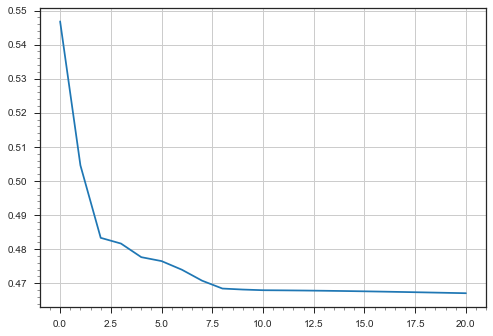

In [18]:
irgd21 = regr.r_regression_irls(Xs, Y, mod21, rhofunc=func.Sqrt(0.001))

plt.plot(irgd21.lvals)
plt.minorticks_on()
plt.grid(1)
plt.show()

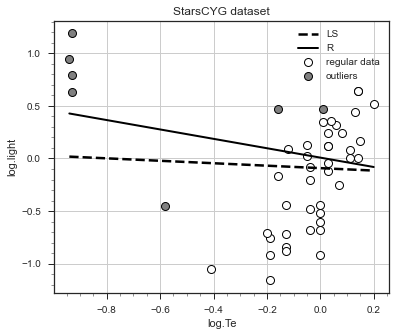

In [19]:
plt.figure(figsize=(6.0, 5.0))
plt.title('StarsCYG dataset')
plt.scatter(X1, Y1, s=64, c='w', edgecolors='k', linewidths=1., label='regular data')
plt.scatter(X1_, Y1_, s=64, c='Grey', edgecolors='k', linewidths=1., label='outliers')
plt.plot(X0, mod1.evaluate_all(X0.reshape(-1,1)), c='k', linestyle='--', linewidth=2.5, label=r'LS')
plt.plot(X0, mod21.evaluate_all(X0.reshape(-1,1)), color='k', linewidth=2., label=r'R')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.legend(loc='best')
plt.show()

In [55]:
mod22 = model.LinearModel(1)
mod22.init()

step: 1
K=1000 param=[-0.11259589  1.55902005]


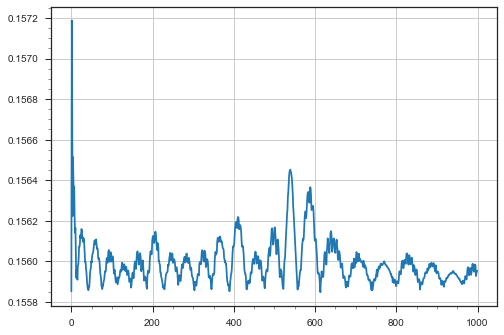

In [61]:
avg22 = regr.averaging_function('WM', rhofunc=func.Quantile_Sqrt(0.84, 0.001))
alg_fg2 = regr.m_regression(Xs, Y, mod22, avrfunc=avg22, h=0.01, tol=1.0e-6)

plt.plot(alg_fg2.lvals)
plt.minorticks_on()
plt.grid(1)
plt.show()

In [60]:
alg_fg2.lvals

[0.3022698541816568,
 0.29753195020839796,
 0.29218342937602276,
 0.28668771094298895,
 0.2811879941704912,
 0.27576080599809616,
 0.2704315463750571,
 0.2652636119819139,
 0.2602541903611026,
 0.25541016453051707,
 0.2507529518661873,
 0.24628590318011756,
 0.24200849893567591,
 0.2379235056029703,
 0.234026831123483,
 0.23034936914693205,
 0.22687226407037347,
 0.22359428974697831,
 0.2204865116266737,
 0.2173520771303457,
 0.21431359408164363,
 0.21230075625797976,
 0.21318516854072964,
 0.21402829263746356,
 0.2147988918346638,
 0.2154801586645768,
 0.21605748597633728,
 0.21654763742155822,
 0.21694896198658728,
 0.21725234977828908,
 0.2174528078277743,
 0.21754939924572053,
 0.21754651757068488,
 0.21743645858764274,
 0.21722480928336207,
 0.21691231479530443,
 0.21650173638267153,
 0.21599804637533587,
 0.2154002158656748,
 0.21471867550709975,
 0.21395242353420377,
 0.21310384023759033,
 0.21218532425903744,
 0.21119583888235213,
 0.21014170233708518,
 0.20902650388448274,
 0.

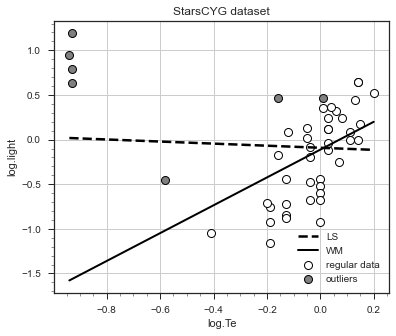

In [57]:
plt.figure(figsize=(6.0, 5.0))
plt.title('StarsCYG dataset')
plt.scatter(X1, Y1, s=64, c='w', edgecolors='k', linewidths=1., label='regular data')
plt.scatter(X1_, Y1_, s=64, c='Grey', edgecolors='k', linewidths=1., label='outliers')
plt.plot(X0, mod1.evaluate_all(X0.reshape(-1,1)), c='k', linestyle='--', linewidth=2.5, label=r'LS')
plt.plot(X0, mod22.evaluate_all(X0.reshape(-1,1)), color='k', linewidth=2., label=r'WM')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.legend(loc='best')
plt.show()

In [23]:
mod3 = model.LinearModel(1)
mod3.init()

step: 1
K=1000 param=[-0.15102023  3.02255583]


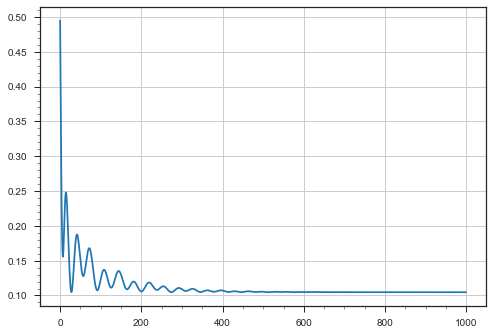

In [24]:
# er3 = erisk(X1s, Y1, mod3, loss_func_sq)
# alg_fg3 = erm_fg(er3, h=0.01, tol=1.0e-6, verbose=0)

alg_fg3 = regr.regression(X1s, Y1, mod3, h=0.1, tol=1.0e-6)

plt.plot(alg_fg3.lvals)
plt.minorticks_on()
plt.grid(1)
plt.show()

In [25]:
mod4 = model.LinearModel(1)
mod4.init()

step: 1


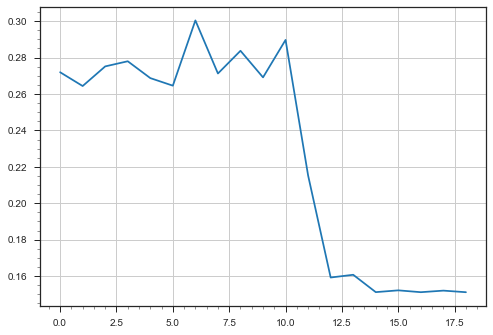

In [26]:
# er4 = erisk(Xs, Y, mod4, loss_func_sq)
# alg_fg4 = fg(er4, h=0.001, tol=1.0e-9)
# avg4 = averager_it(func.QuantileFunc(0.84, func.Sqrt(0.001)))
# avg4 = avragg.HMAverage(avg4)
# wg4 = weights.MWeights(avg4, er4)
# irgd4 = erm_irgd(alg_fg4, wg4, n_iter=22, tol=1.0e-5)

avg4 = regr.averaging_function('HM', rhofunc=func.Quantile_Sqrt(0.84, 0.001))
irgd4 = regr.m_regression_irls(Xs, Y, mod4, avrfunc=avg4, h=0.1, tol=1.0e-9, n_iter2=22, tol2=1.0e-5)

plt.plot(irgd4.lvals)
plt.minorticks_on()
plt.grid(1)
plt.show()

In [27]:
Err = np.abs(Y - mod4.evaluate_all(Xs))

X2, X2_ = array_exclude_outliers(X, Err, 6) 
Y2, Y2_ = array_exclude_outliers(Y, Err, 6) 
X2s = X2.reshape(-1,1)

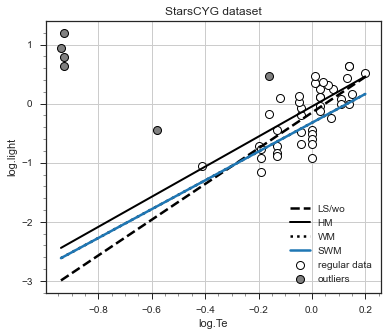

In [28]:
plt.figure(figsize=(6.0, 5.0))
plt.title('StarsCYG dataset')
plt.scatter(X2, Y2, s=64, c='w', edgecolors='k', linewidths=1., label='regular data')
plt.scatter(X2_, Y2_, s=64, c='Grey', edgecolors='k', linewidths=1., label='outliers')
plt.plot(X0, mod3.evaluate_all(X0.reshape(-1,1)), c='k', linestyle='--', linewidth=2.5, label=r'LS/wo')
plt.plot(X0, mod4.evaluate_all(X0.reshape(-1,1)), color='k', linewidth=2., label=r'HM')
plt.plot(X0, mod2.evaluate_all(X0.reshape(-1,1)), c='k', linestyle=':', linewidth=2.5, label=r'WM')
plt.plot(X0, mod2.evaluate_all(X0.reshape(-1,1)), linewidth=2.5, label=r'SWM')
plt.minorticks_on()
plt.grid(1)
plt.xlabel('log.Te')
plt.ylabel('log.light')
plt.legend(loc='best')
plt.show()

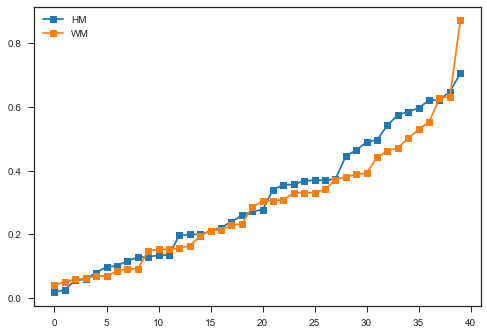

In [29]:
res3 = np.abs(Y1 - mod2.evaluate_all(X1s))
res3.sort()
res4 = np.abs(Y1 - mod4.evaluate_all(X1s))
res4.sort()
plt.plot(res3, marker='s', label='HM')
plt.plot(res4, marker='s', label='WM')
plt.legend()
plt.show()

In [30]:
40/47

0.851063829787234